# TODO: Inventory Monitoring at Distribution Centers
# 📦 Automated Inventory Management using Computer Vision

Manual inventory management is labor-intensive and prone to human error, which can lead to inefficiencies, inaccuracies, and increased operational costs. As businesses scale, the complexity and volume of inventory operations grow, making manual processes unsustainable.

This project proposes an **automated inventory management system** powered by **Computer Vision and Machine Learning**. The primary goal is to eliminate human error, reduce labor requirements, and improve real-time visibility into inventory levels — ultimately driving operational efficiency and cost savings.

## 🚀 Key Benefits of Automation:
- 🔁 **Eliminates manual counting errors**
- ⏱️ **Reduces workforce dependency and time consumption**
- 📈 **Improves scalability** for large warehouses and dynamic inventories
- 📊 **Provides measurable results** via model-driven insights

## 🧠 Problem Statement
Inventory tracking is framed as a **classification and object counting problem**. Given a real-time input image (e.g., from a live camera feed), the system predicts:
- The **class** of items present
- The **count** of items in the bin

This is achieved using a trained deep learning model that generalizes to different object types by adapting to respective datasets.

## 🛠️ Solution Overview
This notebook outlines:
- Data acquisition and preprocessing
- Model training using image classification techniques
- Deployment strategy for real-time inference
- Evaluation metrics to assess system performance

The solution is designed to be **modular and scalable**, making it suitable for deployment across

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks.

In [1]:
# TODO: Install any packages that you might need
!pip install smdebug

  Using cached smdebug-1.0.34-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached pyinstrument_cext-0.2.4-cp312-cp312-linux_x86_64.whl
Using cached smdebug-1.0.34-py2.py3-none-any.whl (280 kB)
Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.28.3
    Uninstalling protobuf-5.28.3:
      Successfully uninstalled protobuf-5.28.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [smdebug]m3/4 [smdebug]]


In [2]:
# TODO: Import any packages that you might need
import sagemaker
import os
import boto3
from sagemaker.tuner import (IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner) 
from sagemaker.pytorch import PyTorch
import sagemaker.debugger
from sagemaker.debugger import (Rule, ProfilerRule, rule_configs, DebuggerHookConfig, ProfilerConfig, FrameworkProfile, CollectionConfig)
from tqdm import tqdm

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [7]:
import os
import json
import boto3

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

100%|██████████| 1228/1228 [01:35<00:00, 12.89it/s]


100%|██████████| 2299/2299 [03:07<00:00, 12.28it/s]


100%|██████████| 2666/2666 [03:38<00:00, 12.22it/s]


100%|██████████| 2373/2373 [03:15<00:00, 12.14it/s]


100%|██████████| 1875/1875 [02:28<00:00, 12.66it/s]


## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. 


Dataset Name: Amazon Bin Image Dataset
Size: ~500,000 labeled images and we are using more than 10000 samples 
Input Features:

RGB bin images of various object quantities.

Metadata JSON files for each image (contains count, dimensions, type).

Data Characteristics:

High variability in object type, shape, and orientation.

Imbalanced class distribution (some counts appear more frequently).

Images are stored in structured directories.

Source: Provided via project portal or AWS public datasets.

Data Usage:

Image: Input for CNN.

Label (object count): Target for classification.

Data will be stored in Amazon S3You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

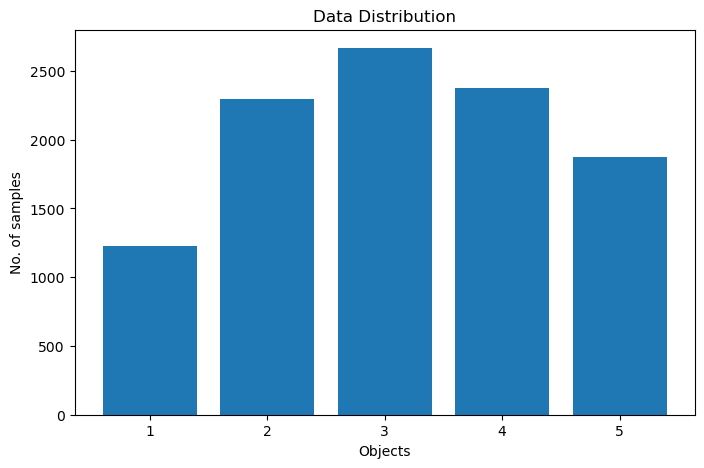

In [3]:
#TODO: Perform any data cleaning or data preprocessing
#dataset_samples = [1228 amples with 1 object,2299 with 2, 2666 with 3,2373 with 4,1875 with 5 objects]

import numpy as np 
from matplotlib import pyplot as plt 

data = {"1":1228, "2":2299, "3":2666, "4":2373, "5":1875} 
objects = list(data.keys()) 
samples = list(data.values()) 
fig = plt.figure(figsize =(8,5)) 

#creating the bar plot
plt.bar(objects, samples) 

plt.xlabel("Objects") 
plt.ylabel("No. of samples") 
plt.title("Data Distribution") 
plt.show()




In [4]:
sagemaker_session = sagemaker.Session()

role = sagemaker.get_execution_role()

print(role)

arn:aws:iam::381491983227:role/service-role/AmazonSageMaker-ExecutionRole-20250128T162863


In [5]:
#TODO: Upload the data to AWS S3
os.environ['SM_CHANNEL_TRAINING']='s3://capstoneproject-udacity/'
os.environ['SM_MODEL_DIR']='s3://capstoneproject-udacity/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://capstoneproject-udacity/output/'


In [14]:
%%capture
!aws s3 cp train_data s3://capstoneproject-udacity/ --recursive

In [6]:
s3_data_path = 's3://capstoneproject-udacity/'
s3_data_path

's3://capstoneproject-udacity/'

### Hyperparameter Tuning

It's time to finetune a pretrained model with hyperparameter tuning. The selected parameters are:

1.learning rate: to have a faster convergence

2.batch size: to have an efficient training time

3.epochs: to have an efficient training time

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [9]:
#HP Range, metrics etc
hyperparameter_ranges = {"learning_rate": ContinuousParameter(0.001,0.1), 
                        "batch_size": CategoricalParameter([16,32,64]), 
                        "epochs": IntegerParameter(0,50)} 

In [10]:
obejective_metric_name= "Test Accuracy" 
objective_type = "Minimize" 
metric_definition =[{'Name': 'Test Accuracy', 'Regex': 'Test Accuracy: ([0-9\\.]+)'}]

In [30]:
#TODO: Declare your model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values

In [11]:
#TODO: Create your training estimator
estimator = PyTorch(entry_point= "tuner.py", 
                    base_job_name= "Inventory-monitoring",
                    role=role, 
                    py_version="py38", 
                    framework_version="1.12", 
                    instance_count=1, 
                    instance_type="ml.g4dn.xlarge") 

tuner = HyperparameterTuner(estimator=estimator,
                            objective_metric_name=obejective_metric_name, 
                            hyperparameter_ranges=hyperparameter_ranges, 
                            metric_definitions=metric_definition,
                             
                            objective_type=objective_type,  
                            max_jobs=1,  
                            max_parallel_jobs=1) 
    

In [12]:
# TODO: Fit your estimator
tuner.fit({"training": s3_data_path}, wait=True) 

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


................................................................................................................................................................................................................................................................................................................................................................................................................................!


## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Find the best Hyperparameter

In [13]:
tuner.describe()

{'HyperParameterTuningJobName': 'pytorch-training-250619-1500',
 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:381491983227:hyper-parameter-tuning-job/pytorch-training-250619-1500',
 'HyperParameterTuningJobConfig': {'Strategy': 'Bayesian',
  'HyperParameterTuningJobObjective': {'Type': 'Minimize',
   'MetricName': 'Test Accuracy'},
  'ResourceLimits': {'MaxNumberOfTrainingJobs': 1,
   'MaxParallelTrainingJobs': 1},
  'ParameterRanges': {'IntegerParameterRanges': [{'Name': 'epochs',
     'MinValue': '0',
     'MaxValue': '50',
     'ScalingType': 'Auto'}],
   'ContinuousParameterRanges': [{'Name': 'learning_rate',
     'MinValue': '0.001',
     'MaxValue': '0.1',
     'ScalingType': 'Auto'}],
   'CategoricalParameterRanges': [{'Name': 'batch_size',
     'Values': ['"16"', '"32"', '"64"']}]},
  'TrainingJobEarlyStoppingType': 'Off'},
 'TrainingJobDefinition': {'StaticHyperParameters': {'_tuning_objective_metric': 'Test Accuracy',
   'sagemaker_container_log_level': '20',
  

In [14]:
tuner.describe().keys()

dict_keys(['HyperParameterTuningJobName', 'HyperParameterTuningJobArn', 'HyperParameterTuningJobConfig', 'TrainingJobDefinition', 'HyperParameterTuningJobStatus', 'CreationTime', 'HyperParameterTuningEndTime', 'LastModifiedTime', 'TrainingJobStatusCounters', 'ObjectiveStatusCounters', 'BestTrainingJob', 'TuningJobCompletionDetails', 'ConsumedResources', 'ResponseMetadata'])

In [15]:
tuner.describe()['HyperParameterTuningJobName']

'pytorch-training-250619-1500'

In [16]:
from sagemaker.analytics import HyperparameterTuningJobAnalytics

exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name=tuner.describe()['HyperParameterTuningJobName'])

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

,batch_size,epochs,learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""16""",25.0,0.006289,pytorch-training-250619-1500-001-a2118013,Completed,28.860001,2025-06-19 15:01:23+00:00,2025-06-19 15:32:05+00:00,1842.0


In [17]:
# Best estimators
best_estimator = tuner.best_estimator()
best_estimator.hyperparameters()


2025-06-19 15:32:07 Starting - Preparing the instances for training
2025-06-19 15:32:07 Downloading - Downloading the training image
2025-06-19 15:32:07 Training - Training image download completed. Training in progress.
2025-06-19 15:32:07 Uploading - Uploading generated training model
2025-06-19 15:32:07 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': '"Test Accuracy"',
 'batch_size': '"16"',
 'epochs': '25',
 'learning_rate': '0.006288988797005023',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"Inventory-monitoring-2025-06-19-15-00-17-113"',
 'sagemaker_program': '"tuner.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-381491983227/Inventory-monitoring-2025-06-19-15-00-17-113/source/sourcedir.tar.gz"'}

In [18]:
#
best_hyperparameters = {
    "batch_size":int(best_estimator.hyperparameters()['batch_size'].replace('"',"")), 
    "epochs":best_estimator.hyperparameters()['epochs'], 
    'learning_rate': best_estimator.hyperparameters()['learning_rate'] }

#### Model Profiling and Debugging


In [22]:
# 
rules = [Rule.sagemaker(rule_configs.vanishing_gradient()), 
         Rule.sagemaker(rule_configs.overfit()), 
         Rule.sagemaker(rule_configs.overtraining()), 
         Rule.sagemaker(rule_configs.poor_weight_initialization()), 
         ProfilerRule.sagemaker(rule_configs.ProfilerReport()),]  

hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "100", 
        "eval.save_interval": "10"},
    collection_configs=[
        CollectionConfig(name='losses', parameters={'save_interval': '1'}),
        CollectionConfig(name='weights', parameters={'save_interval': '200'})
    ])

profiler_config = ProfilerConfig(system_monitor_interval_millis=500)



## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [23]:
estimator = PyTorch(entry_point= "train.py", 
                    role = role, 
                    py_version= "py38", 
                    base_job_name= "inventory-monitoring", 
                    framework_version="1.12",  
                    instance_count= 1, 
                    instance_type= "ml.g4dn.xlarge", 
                    hyperparameters=best_hyperparameters, 
                    rules= rules, 
                    debugger_hook_config=hook_config, 
                    profiler_config=profiler_config) 

                    
                    
                    

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [24]:
# TODO: Set up debugging and profiling rules and hooks
estimator.fit({"training": s3_data_path}, wait=True) 

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: inventory-monitoring-2025-06-19-15-40-11-188


2025-06-19 15:40:11 Starting - Starting the training job...
2025-06-19 15:40:44 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2025-06-19 15:41:13 Downloading - Downloading input data......
2025-06-19 15:42:12 Downloading - Downloading the training image.....................
2025-06-19 15:45:42 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2025-06-19 15:45:49,408 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2025-06-19 15:45:49,431 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2025-06-19 15:45:49,443 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2025-06-19 15:45:49,511 sagemaker_pytorc

In [25]:
import boto3

session = boto3.session.Session()
region = session.region_name
bucket = sagemaker_session.default_bucket()

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")
print(f"Bucket: {bucket}")

Training jobname: inventory-monitoring-2025-06-19-15-40-11-188
Region: us-east-1
Bucket: sagemaker-us-east-1-381491983227


In [26]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=job_name)

In [27]:
# TODO: Create and fit an estimator
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

trial.tensor_names()

[2025-06-19 16:19:02.994 default:176 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-06-19 16:19:03.108 default:176 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-381491983227/inventory-monitoring-2025-06-19-15-40-11-188/debug-output
[2025-06-19 16:23:15.090 default:176 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2025-06-19 16:23:16.108 default:176 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'EfficientNet_classifier.0.weight',
 'EfficientNet_classifier.3.weight',
 'EfficientNet_features.0.0.weight',
 'EfficientNet_features.0.1.weight',
 'EfficientNet_features.1.0.block.0.0.weight',
 'EfficientNet_features.1.0.block.0.1.weight',
 'EfficientNet_features.1.0.block.1.fc1.weight',
 'EfficientNet_features.1.0.block.1.fc2.weight',
 'EfficientNet_features.1.0.block.2.0.weight',
 'EfficientNet_features.1.0.block.2.1.weight',
 'EfficientNet_features.1.1.block.0.0.weight',
 'EfficientNet_features.1.1.block.0.1.weight',
 'EfficientNet_features.1.1.block.1.fc1.weight',
 'EfficientNet_features.1.1.block.1.fc2.weight',
 'EfficientNet_features.1.1.block.2.0.weight',
 'EfficientNet_features.1.1.block.2.1.weight',
 'EfficientNet_features.2.0.block.0.0.weight',
 'EfficientNet_features.2.0.block.0.1.weight',
 'EfficientNet_features.2.0.block.1.0.weight',
 'EfficientNet_features.2.0.block.1.1.weight',
 'EfficientNet_features.2.0.block.2.fc1.weight',
 'EfficientNe

In [28]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

11425

In [29]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

2548

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

The training job for the inventory monitoring model using AWS SageMaker successfully completed with a PyTorch-based implementation leveraging a pretrained EfficientNetB3 architecture. The model was trained over 25 epochs with a batch size of 16 and a learning rate of approximately 0.0063 on a ml.g4dn.xlarge GPU instance. Despite successful execution, the model's performance showed limited improvement, achieving a test accuracy of only 28.42%, suggesting issues such as overtraining and potential overfitting. The validation loss showed some improvement but plateaued, indicating the model struggled to generalize well on unseen data. These results highlight the need for further optimization, including hyperparameter tuning, data augmentation, or model architecture refinement to improve predictive accuracy in counting objects within bins for inventory applications.

In [37]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):
    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

In [40]:
#plot_tensor(trial, "CrossEntropyLoss_output_0")

Because of the length it is hard to plot the graph of losses 

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [41]:
# TODO: Deploy your model to an endpoint
model = estimator.model_data 
print(model)

s3://sagemaker-us-east-1-381491983227/inventory-monitoring-2025-06-19-15-40-11-188/output/model.tar.gz


In [42]:
!pip install bokeh -q

In [43]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob


tj = TrainingJob(training_job_name, region)
# Display Report 
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-381491983227/', 'ProfilingIntervalInMilliseconds': 500, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-381491983227/inventory-monitoring-2025-06-19-15-40-11-188/profiler-output


Profiler data from system is available


In [44]:
output_path = estimator.output_path
latest_training_job = estimator.latest_training_job.job_name
print(f"Latest Training jobname: {latest_training_job}")
print(f"Output Path: {output_path}")

Latest Training jobname: inventory-monitoring-2025-06-19-15-40-11-188
Output Path: s3://sagemaker-us-east-1-381491983227/


In [45]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [46]:
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

2025-06-19 16:16:24     370589 inventory-monitoring-2025-06-19-15-40-11-188/rule-output/ProfilerReport/profiler-output/profiler-report.html
2025-06-19 16:16:23     219375 inventory-monitoring-2025-06-19-15-40-11-188/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2025-06-19 16:16:18        571 inventory-monitoring-2025-06-19-15-40-11-188/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2025-06-19 16:16:18      12224 inventory-monitoring-2025-06-19-15-40-11-188/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2025-06-19 16:16:18        126 inventory-monitoring-2025-06-19-15-40-11-188/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2025-06-19 16:16:18        130 inventory-monitoring-2025-06-19-15-40-11-188/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2025-06-19 16:16:18        736 inventory-monitoring-2025-06-19-15-40-11-188/rule-output/ProfilerReport

In [47]:
rules = estimator.latest_training_job.rule_job_summary()
for rule in rules:
    print(rule["RuleConfigurationName"])

VanishingGradient
Overfit
Overtraining
PoorWeightInitialization
ProfilerReport


In [48]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [49]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [50]:
from sagemaker.pytorch import PyTorchModel
model_data = estimator.model_data
print(f"Model: {model_data}")

Model: s3://sagemaker-us-east-1-381491983227/inventory-monitoring-2025-06-19-15-40-11-188/output/model.tar.gz


In [51]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [52]:
pytorch_model = PyTorchModel(
    model_data=model_data,     
    role=role,
    entry_point='inference.py',
    framework_version='1.12',
    py_version='py38',
    predictor_cls=ImagePredictor
)

In [54]:
predictor = pytorch_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    endpoint_name='inventory-image-classifier-endpoint'
)

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-381491983227/inventory-monitoring-2025-06-19-15-40-11-188/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-381491983227/pytorch-inference-2025-06-19-19-51-16-208/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2025-06-19-19-51-52-764
INFO:sagemaker:Creating endpoint-config with name inventory-image-classifier-endpoint
INFO:sagemaker:Creating endpoint with name inventory-image-classifier-endpoint


------!

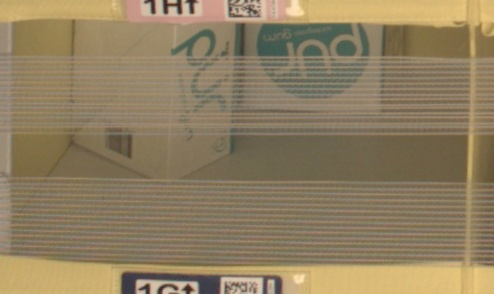

In [55]:
from PIL import Image
import io
import requests
request_dict={ "url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/777.jpg" }
img_bytes = requests.get(request_dict['url']).content
Image.open(io.BytesIO(img_bytes))

In [56]:
import json
response=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})

In [57]:
response

{'predicted_class_index': 1,
 'predicted_label': '2',
 'probabilities': [0.4031025171279907,
  0.4376782476902008,
  0.09387456625699997,
  0.04467049613595009,
  0.020674139261245728]}

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [ ]:
multi_instance = PyTorch(entry_point= "train.py", 
                    role = role, 
                    py_version= "py38", 
                    base_job_name= "Multi-instance-job", 
                    framework_version="1.12",  
                    instance_count= 2, 
                    instance_type= "ml.m5.xlarge", 
                    hyperparameters=best_hyperparameters) 
                     
                    
             
multi_instance.fit({"training": s3_data_path}, wait=True) 

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: Multi-instance-job-2025-06-19-19-56-34-457


2025-06-19 19:56:39 Starting - Starting the training job...
2025-06-19 19:56:52 Starting - Preparing the instances for training...
2025-06-19 19:57:15 Downloading - Downloading input data...